# Data Output

Similarly important to data input is data output. Using a data output module allows you to restructure and rename computed output and to spatially differentiate relevant output files from the temporary computed intermediate files in the working directory. Nipype provides the following modules to handle data stream output:

    DataSink
    JSONFileSink
    MySQLSink
    SQLiteSink
    XNATSink

This tutorial covers only `DataSink`. For the rest, see the section [``interfaces.io``](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html) on the official homepage.

# DataSink

A workflow working directory is like a **cache**. It contains not only the outputs of various processing stages, it also contains various extraneous information such as execution reports, hashfiles determining the input state of processes. All of this is embedded in a hierarchical structure that reflects the iterables that have been used in the workflow. This makes navigating the working directory a not so pleasant experience. And typically the user is interested in preserving only a small percentage of these outputs. The [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) interface can be used to extract components from this `cache` and store it at a different location. For XNAT-based storage, see [XNATSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#nipype-interfaces-io-xnatsink).

<div class="alert alert-info">
Unlike other interfaces, a [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink)'s inputs are defined and created by using the workflow connect statement. Currently disconnecting an input from the [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) does not remove that connection port.
</div>

Let's assume we have the following workflow.

<img src="../static/images/datasink_flow.png" width="160">

The following code segment defines the [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) node and sets the `base_directory` in which all outputs will be stored. The `container` input creates a subdirectory within the `base_directory`. If you are iterating a workflow over subjects, it may be useful to save it within a folder with the subject id.


```python
datasink = pe.Node(nio.DataSink(), name='sinker')
datasink.inputs.base_directory = '/path/to/output'
workflow.connect(inputnode, 'subject_id', datasink, 'container')
```

If we wanted to save the realigned files and the realignment parameters to the same place the most intuitive option would be:

```python
workflow.connect(realigner, 'realigned_files', datasink, 'motion')
workflow.connect(realigner, 'realignment_parameters', datasink, 'motion')
```

However, this will not work as only one connection is allowed per input port. So we need to create a second port. We can store the files in a separate folder.

```python
workflow.connect(realigner, 'realigned_files', datasink, 'motion')
workflow.connect(realigner, 'realignment_parameters', datasink, 'motion.par')
```

The period (.) indicates that a subfolder called par should be created. But if we wanted to store it in the same folder as the realigned files, we would use the `.@` syntax. The @ tells the [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) interface to not create the subfolder. This will allow us to create different named input ports for [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) and allow the user to store the files in the same folder.

```python
workflow.connect(realigner, 'realigned_files', datasink, 'motion')
workflow.connect(realigner, 'realignment_parameters', datasink, 'motion.@par')
```

The syntax for the input port of [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) takes the following form:

    string[[.[@]]string[[.[@]]string] ...]
    where parts between paired [] are optional.

## MapNode

In order to use [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) inside a MapNode, its inputs have to be defined inside the constructor using the `infields` keyword arg.

## Parameterization

As discussed in [Iterables](basic_iteration.ipynb), one can run a workflow iterating over various inputs using the iterables attribute of nodes. This means that a given workflow can have multiple outputs depending on how many iterables are there. Iterables create working directory subfolders such as `_iterable_name_value`.  The `parameterization` input parameter controls whether the data stored using [DataSink](http://nipype.readthedocs.io/en/latest/interfaces/generated/nipype.interfaces.io.html#datasink) is in a folder structure that contains this iterable information or not. It is generally recommended to set this to `True` when using multiple nested iterables.

## Substitutions

The ``substitutions`` and ``regexp_substitutions`` inputs allow users to modify the output destination path and name of a file. Substitutions are a list of 2-tuples and are carried out in the order in which they were entered. Assuming that the output path of a file is:

    /root/container/_variable_1/file_subject_realigned.nii

we can use substitutions to clean up the output path.

```python
datasink.inputs.substitutions = [('_variable', 'variable'),
                                 ('file_subject_', '')]
```

This will rewrite the file as:

    /root/container/variable_1/realigned.nii


<div class="alert alert-info">
**Note**: In order to figure out which substitutions are needed it is often useful to run the workflow on a limited set of iterables and then determine the substitutions.
</div>

# Realistic Example

## Preparation

Before we can use `DataSink` we first need to run a workflow. For this purpose, let's create a very short preprocessing workflow that realigns and smooths one functional image of one subject.

First, let's create a `SelectFiles` node. For an explanation of this step, see the [Data Input](basic_data_input.ipynb) tutorial.

In [15]:
from nipype import SelectFiles, Node

# Create SelectFiles node
templates={'func': '{subject}/{session}/func/{subject}_{session}_task-fingerfootlips_bold.nii.gz'}
sf = Node(SelectFiles(templates),
          name='selectfiles')
sf.inputs.base_directory = '/home/neuro/Data/ds000114'
sf.inputs.subject = 'sub-01'
sf.inputs.session = 'ses-test'

Second, let's create the motion correction and smoothing node. For an explanation about this step, see the [Nodes](basic_nodes.ipynb) and [Interfaces](basic_interfaces.ipynb) tutorial.

In [17]:
from nipype.interfaces.fsl import MCFLIRT, IsotropicSmooth

# Create Motion Correction Node
mcflirt = Node(MCFLIRT(mean_vol=True,
                       save_plots=True),
               name='mcflirt')

# Create Smoothing node
smooth = Node(IsotropicSmooth(fwhm=4),
              name='smooth')

Third, let's create the workflow that will contain those three nodes. For an explanation about this step, see the [Workflow](basic_workflow.ipynb) tutorial.

In [18]:
from nipype import Workflow
from os.path import abspath

# Create a preprocessing workflow
wf = Workflow(base_dir='/home/neuro/Result/Nipype_tutorial/working_dir', name="preprocWF")

# Connect the three nodes to each other
wf.connect([(sf, mcflirt, [("func", "in_file")]),
            (mcflirt, smooth, [("out_file", "in_file")])])

Now that everything is set up, let's run the preprocessing workflow.

In [19]:
wf.run()

211103-08:29:51,664 nipype.workflow INFO:
	 Workflow preprocWF settings: ['check', 'execution', 'logging', 'monitoring']
211103-08:29:51,708 nipype.workflow INFO:
	 Running serially.
211103-08:29:51,709 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/selectfiles".
211103-08:29:51,734 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211103-08:29:51,757 nipype.workflow INFO:
	 [Node] Finished "preprocWF.selectfiles".
211103-08:29:51,758 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.mcflirt" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/mcflirt".
211103-08:29:51,789 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Data/ds000114/sub-01/ses-test/func/sub-01_ses-test_task-fingerfootlips_bold.nii.gz -meanvol -out /home/neuro/Result/Nipype_tutorial

After the execution of the workflow we have all the data hidden in the working directory `'working_dir'`. Let's take a closer look at the content of this folder:

As we can see, there is way too much content that we might not really care about. To relocate and rename all the files that are relevant to you, you can use `DataSink`.

## How to use `DataSink`

`DataSink` is Nipype's standard output module to restructure your output files. It allows you to relocate and rename files that you deem relevant.

Based on the preprocessing pipeline above, let's say we want to keep the smoothed functional images as well as the motion correction parameters. To do this, we first need to create the `DataSink` object.

In [22]:
mcflirt.outputs


mat_file = <undefined>
mean_img = <undefined>
out_file = <undefined>
par_file = <undefined>
rms_files = <undefined>
std_img = <undefined>
variance_img = <undefined>

In [23]:
from nipype.interfaces.io import DataSink

# Create DataSink object
sinker = Node(DataSink(base_directory = '/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF_output'), name='sinker')

# Connect DataSink with the relevant nodes
wf.connect([(smooth, sinker, [('out_file', 'in_file')]),
            (mcflirt, sinker, [('mean_img', 'mean_img'),
                               ('par_file', 'par_file')]),
            ])
wf.run()

211103-08:45:47,459 nipype.workflow INFO:
	 Workflow preprocWF settings: ['check', 'execution', 'logging', 'monitoring']
211103-08:45:47,477 nipype.workflow INFO:
	 Running serially.
211103-08:45:47,478 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/selectfiles".
211103-08:45:47,513 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211103-08:45:47,536 nipype.workflow INFO:
	 [Node] Finished "preprocWF.selectfiles".
211103-08:45:47,536 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.mcflirt" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/mcflirt".
211103-08:45:47,544 nipype.workflow INFO:
	 [Node] Outdated cache found for "preprocWF.mcflirt".
211103-08:45:47,590 nipype.workflow INFO:
	 [Node] Running "mcflirt" ("nipype.interfaces.fsl.preprocess.MCFLIRT"), a CommandLine Interface with command:
mcflirt -in /home/neuro/Data/ds000114/sub-01/ses-test/func

Let's take a look at the `output` folder:

211103-08:52:02,562 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/wf_flat.png (graph2use=flat, simple_form=True).


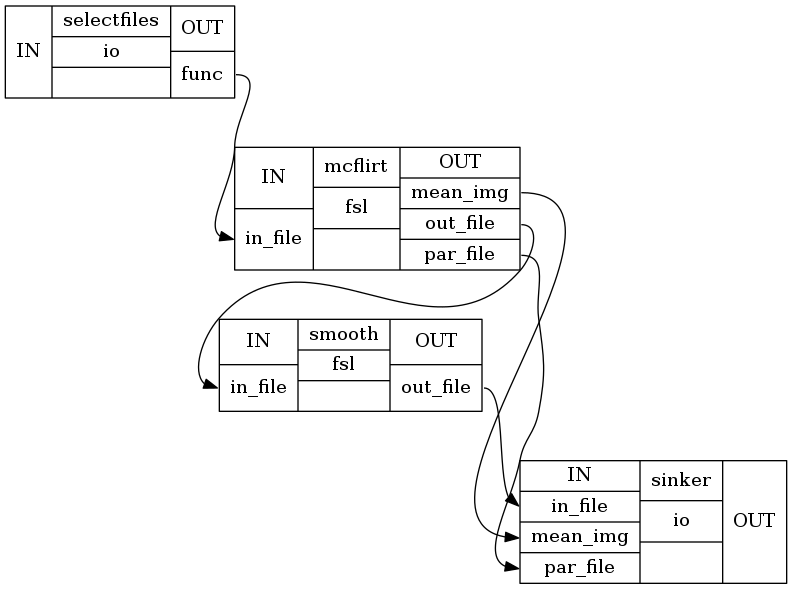

In [27]:
wf.write_graph(dotfilename='wf_flat.dot', graph2use='flat')
from IPython.display import Image
Image('/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/wf_flat_detailed.png')

This looks nice. It is what we asked it to do. But having a specific output folder for each individual output file might be suboptimal. So let's change the code above to save the output in one folder, which we will call `'preproc'`.

For this we can use the same code as above. We only have to change the connection part:

In [28]:
wf.connect([(smooth, sinker, [('out_file', 'preproc.@in_file')]),
            (mcflirt, sinker, [('mean_img', 'preproc.@mean_img'),
                               ('par_file', 'preproc.@par_file')]),
            ])
wf.run()

211103-09:08:42,377 nipype.workflow INFO:
	 Workflow preprocWF settings: ['check', 'execution', 'logging', 'monitoring']
211103-09:08:42,394 nipype.workflow INFO:
	 Running serially.
211103-09:08:42,395 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/selectfiles".
211103-09:08:42,432 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211103-09:08:42,455 nipype.workflow INFO:
	 [Node] Finished "preprocWF.selectfiles".
211103-09:08:42,456 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.mcflirt" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/mcflirt".
211103-09:08:42,465 nipype.workflow INFO:
	 [Node] Cached "preprocWF.mcflirt" - collecting precomputed outputs
211103-09:08:42,466 nipype.workflow INFO:
	 [Node] "preprocWF.mcflirt" found cached.
211103-09:08:42,466 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.smooth" in "/home/neuro/Result/Nipype_t

Let's take a look at the new output folder structure:

This is already much better. But what if you want to rename the output files to represent something a bit more readable. For this `DataSink` has the `substitution` input field.

For example, let's assume we want to get rid of the string `'task-fingerfootlips'` and `'bold_mcf'` and that we want to rename the mean file, as well as adapt the file ending of the motion parameter file:

In [29]:
# Define substitution strings
substitutions = [('_task-fingerfootlips', ''),
                 ("_ses-test", ""),
                 ('_bold_mcf', ''),
                 ('.nii.gz_mean_reg', '_mean'),
                 ('.nii.gz.par', '.par')]

# Feed the substitution strings to the DataSink node
sinker.inputs.substitutions = substitutions

# Run the workflow again with the substitutions in place
wf.run()

211103-09:19:00,34 nipype.workflow INFO:
	 Workflow preprocWF settings: ['check', 'execution', 'logging', 'monitoring']
211103-09:19:00,52 nipype.workflow INFO:
	 Running serially.
211103-09:19:00,52 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.selectfiles" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/selectfiles".
211103-09:19:00,89 nipype.workflow INFO:
	 [Node] Running "selectfiles" ("nipype.interfaces.io.SelectFiles")
211103-09:19:00,113 nipype.workflow INFO:
	 [Node] Finished "preprocWF.selectfiles".
211103-09:19:00,113 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.mcflirt" in "/home/neuro/Result/Nipype_tutorial/working_dir/preprocWF/mcflirt".
211103-09:19:00,119 nipype.workflow INFO:
	 [Node] Cached "preprocWF.mcflirt" - collecting precomputed outputs
211103-09:19:00,120 nipype.workflow INFO:
	 [Node] "preprocWF.mcflirt" found cached.
211103-09:19:00,120 nipype.workflow INFO:
	 [Node] Setting-up "preprocWF.smooth" in "/home/neuro/Result/Nipype_tutor

Now, let's take a final look at the output folder:

Cool, much clearer filenames!

### Exercise 1
Create a simple workflow for skullstriping with FSL, the first node should use `BET` interface and the second node will be a ``DataSink``. Test two methods of connecting the nodes and check the content of the output directory.

In [66]:
# write your solution here
from nipype.interfaces.fsl import BET
from nipype.interfaces.io import DataSink, SelectFiles
from nipype import Workflow, Node, IdentityInterface


infosource = Node(IdentityInterface(fields=['id']), name='infosource')
infosource.iterables = [('id',['01', '02', '03'])]
select_node = Node(SelectFiles(templates= {'anat':'sub-{id}/ses-retest/anat/*T1w*.nii.gz'}, base_directory='/home/neuro/Data/ds000114'), name='select')
bet_node = Node(BET(mask=True), name='skullstrip')
sinker = Node(DataSink(base_directory = '/home/neuro/Result/Nipype_tutorial/working_dir/preproc_ex1/preproc_output', substitutions=[('ses-retest_','')]
), name='datasink')

ex1_wf = Workflow(base_dir='/home/neuro/Result/Nipype_tutorial/working_dir', name='preproc_ex1')

#first method to connect the nodes
ex1_wf.connect([(infosource, select_node,[('id','id')]), 
                (select_node, bet_node, [('anat', 'in_file')]), 
                (bet_node, sinker, [('out_file', 'bet.@bet_file'),
                                     ('mask_file', 'mask.@mask_file')])])


211103-10:49:47,602 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Nipype_tutorial/working_dir/preproc_ex1/ex1_wf_flat.png (graph2use=flat, simple_form=True).


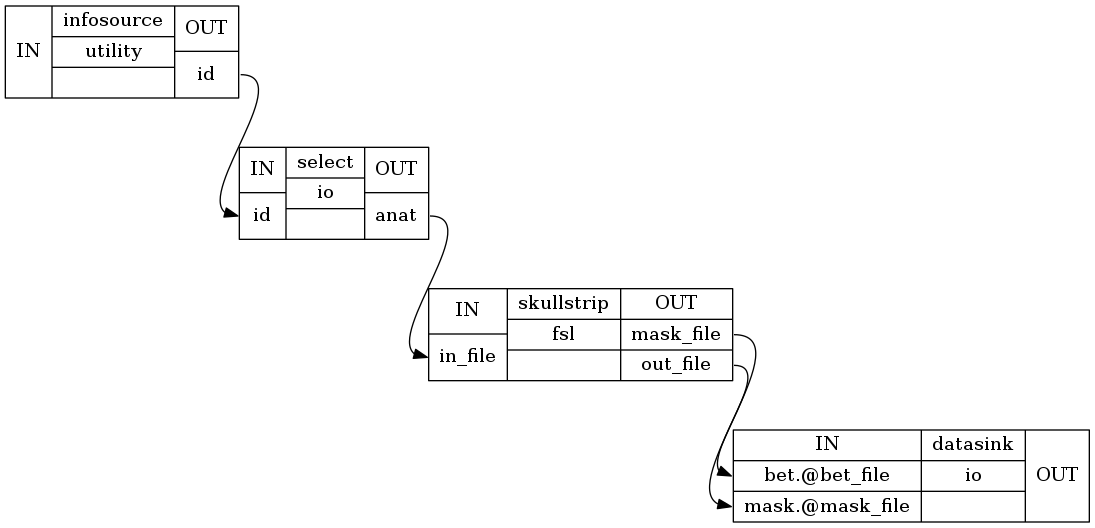

In [67]:
ex1_wf.write_graph('ex1_wf_flat.dot', graph2use='flat')
Image('/home/neuro/Result/Nipype_tutorial/working_dir/preproc_ex1/ex1_wf_flat_detailed.png')

In [68]:
ex1_wf.run()

211103-10:49:49,75 nipype.workflow INFO:
	 Workflow preproc_ex1 settings: ['check', 'execution', 'logging', 'monitoring']
211103-10:49:49,100 nipype.workflow INFO:
	 Running serially.
211103-10:49:49,101 nipype.workflow INFO:
	 [Node] Setting-up "preproc_ex1.select" in "/home/neuro/Result/Nipype_tutorial/working_dir/preproc_ex1/_id_03/select".
211103-10:49:49,145 nipype.workflow INFO:
	 [Node] Running "select" ("nipype.interfaces.io.SelectFiles")
211103-10:49:49,171 nipype.workflow INFO:
	 [Node] Finished "preproc_ex1.select".
211103-10:49:49,171 nipype.workflow INFO:
	 [Node] Setting-up "preproc_ex1.skullstrip" in "/home/neuro/Result/Nipype_tutorial/working_dir/preproc_ex1/_id_03/skullstrip".
211103-10:49:49,176 nipype.workflow INFO:
	 [Node] Cached "preproc_ex1.skullstrip" - collecting precomputed outputs
211103-10:49:49,177 nipype.workflow INFO:
	 [Node] "preproc_ex1.skullstrip" found cached.
211103-10:49:49,178 nipype.workflow INFO:
	 [Node] Setting-up "preproc_ex1.datasink" in "/h

In [ ]:
from nipype import Node, Workflow
from nipype.interfaces.io import DataSink
from nipype.interfaces.fsl import BET

# Skullstrip process
ex1_skullstrip = Node(BET(mask=True), name="ex1_skullstrip")
ex1_skullstrip.inputs.in_file = "/home/neuro/Data/ds000114/sub-01/ses-test/anat/sub-01_ses-test_T1w.nii.gz"

In [ ]:
# Create DataSink node
ex1_sinker = Node(DataSink(), name='ex1_sinker')
ex1_sinker.inputs.base_directory = '/home/neuro/Result/Nipype_tutorial/working_dir/ex1_output'

# and a workflow
ex1_wf = Workflow(name="ex1", base_dir = '/output/working_dir')

In [ ]:
# let's try the first method of connecting the BET node to the DataSink node
ex1_wf.connect([(ex1_skullstrip, ex1_sinker, [('mask_file', 'mask_file'),
                                              ('out_file', 'out_file')]),
            ])
ex1_wf.run()

In [ ]:
# now we can try the other method of connecting the node to DataSink
ex1_wf.connect([(ex1_skullstrip, ex1_sinker, [('mask_file', 'bet.@mask_file'),
                                              ('out_file', 'bet.@out_file')]),
            ])
ex1_wf.run()